# Data Understanding NO2 di Kota Pematang Siantar
Pertama sekali kita harus menginstal library OpenEO untuk mengakses data satelit dari Copernicus Data Space Ecosystem. OpenEO adalah API standar untuk mengakses data Earth Observation secara cloud-based.

In [10]:
pip install openeo

Selanjutnya import ilbrary yang akan digunakan.

In [11]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt

- OpenEO berguna untuk melakukan koneksi layanan data seatelit
- Pendas berguna untuk memanipulasi dan melakukan analisis data
- Matplotlib.pyplot berguna untuk memvisualisasikan data atau hasil

## Koneksi Copernicus Data Space
Pada tahapan membuat koneksi ke server Copernicus Data Space digunakan autentikasi OpenID Conect

In [12]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


## Memotong Daerah Sesuai AOI
Saya menggunakan koordinat Kota Pematangsiantar yang saya dapatkan melalui website geojson.io

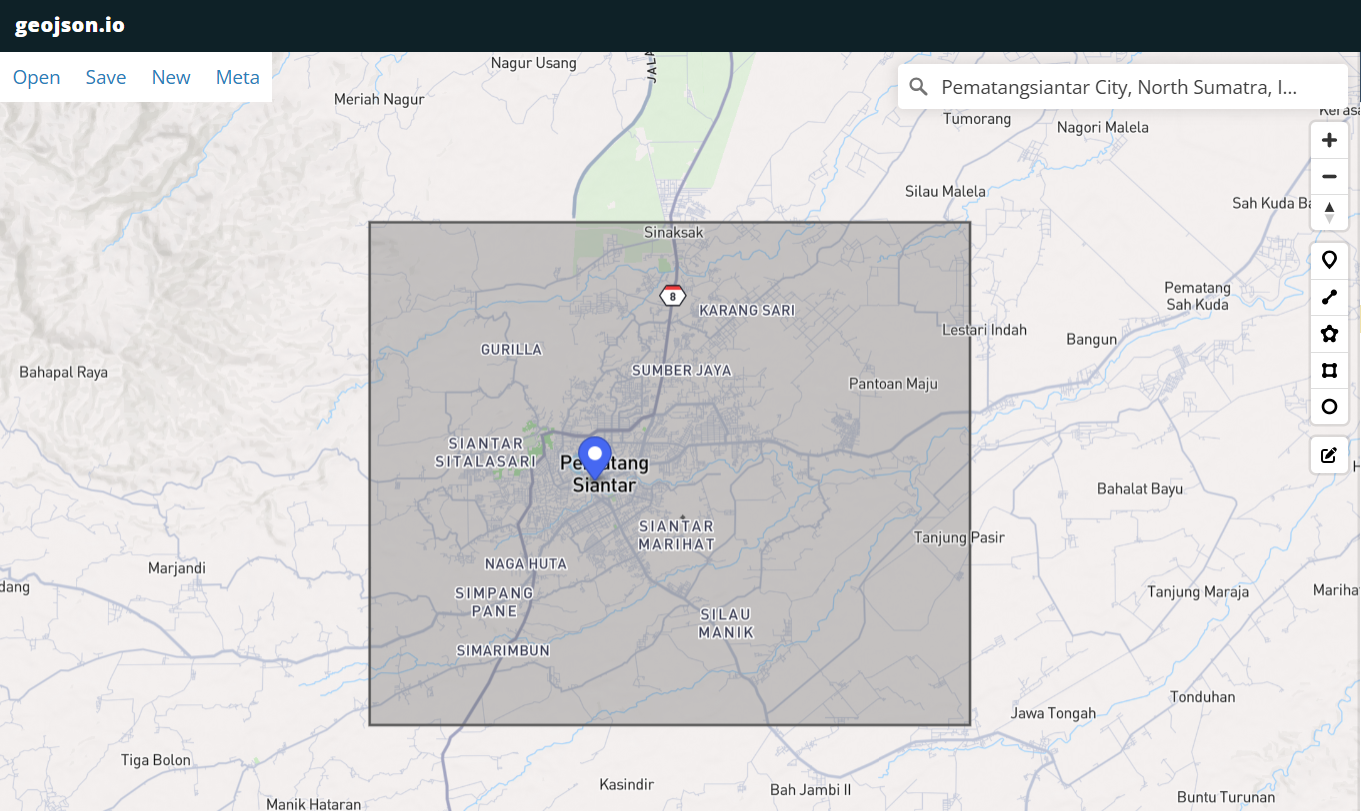

In [13]:
# AOI - Seluruh wilayah Kota Pematang Siantar (perkiraan bounding box)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            # Sudut Kiri Bawah (Min Long, Min Lat)
            [99.016, 2.89],
            # Sudut Kiri Atas (Min Long, Max Lat)
            [99.016, 3.016],
            # Sudut Kanan Atas (Max Long, Max Lat)
            [99.109, 3.016],
            # Sudut Kanan Bawah (Max Long, Min Lat)
            [99.109, 2.89],
            # Kembali ke Kiri Bawah untuk menutup Polygon
            [99.016, 2.89]
        ]
    ]
}

print(aoi)

{'type': 'Polygon', 'coordinates': [[[99.016, 2.89], [99.016, 3.016], [99.109, 3.016], [99.109, 2.89], [99.016, 2.89]]]}


#### Penjelasan
Saya menggunakan batas geografis resmi Kota Pematangsiantar yang disederhanakan (dikonversi dari Derajat-Menit-Detik ke Desimal):
- Bujur (Longitude): $99.016^\circ$ hingga $99.109^\circ$
- Lintang (Latitude): $2.89^\circ$ hingga $3.016^\circ$

ini memberikan definisi AOI yang lebih luas dan mencakup seluruh wilayah Kota Pematangsiantar

In [14]:
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        # Koordinat Pematangsiantar:
        "west": 99.016,     # Bujur Minimum
        "south": 2.89,      # Lintang Minimum
        "east": 99.109,     # Bujur Maksimum
        "north": 3.016,     # Lintang Maksimum
    },
    temporal_extent=["2025-07-01", "2025-10-01"],
    bands=["NO2"],
)

#### Penjelasan
Code ini memuat koleksi data Sentinel 5P level 2 yang daerah nya dibatasi sesuai koordinat Kota Pematangsiantar dan rentang waktunya dari 1 Juli 2025 sampai 1 Oktober 2025, kelompok yang diambil hanya NO2 (nitrogen dioksida).


## Pengambilan Data NO2


In [15]:
# 4. Mask nilai negatif (data invalid)
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal harian
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (rata-rata dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job dan hasilkan file CSV
job = daily_mean_aoi.execute_batch(out_format="CSV",)

# 8. Unduh hasil job
results = job.get_results()
results.download_files("no2_results")

0:00:00 Job 'j-2510241051444c5c928c70867424dff6': send 'start'
0:00:24 Job 'j-2510241051444c5c928c70867424dff6': created (progress 0%)
0:00:29 Job 'j-2510241051444c5c928c70867424dff6': queued (progress 0%)
0:00:37 Job 'j-2510241051444c5c928c70867424dff6': queued (progress 0%)
0:00:45 Job 'j-2510241051444c5c928c70867424dff6': queued (progress 0%)
0:00:56 Job 'j-2510241051444c5c928c70867424dff6': queued (progress 0%)
0:01:08 Job 'j-2510241051444c5c928c70867424dff6': queued (progress 0%)
0:01:24 Job 'j-2510241051444c5c928c70867424dff6': queued (progress 0%)
0:01:43 Job 'j-2510241051444c5c928c70867424dff6': running (progress N/A)
0:02:08 Job 'j-2510241051444c5c928c70867424dff6': running (progress N/A)
0:02:38 Job 'j-2510241051444c5c928c70867424dff6': running (progress N/A)
0:03:16 Job 'j-2510241051444c5c928c70867424dff6': running (progress N/A)
0:04:04 Job 'j-2510241051444c5c928c70867424dff6': finished (progress 100%)


[PosixPath('no2_results/timeseries.csv'),
 PosixPath('no2_results/job-results.json')]

#### Penjelasan
- Pembersihan Data (Masking) berfungsi menghilangkan data yang tidak valid (negatif) dan memastikan keandalan data
- Agregasi Temporal berfungsi merata-ratakan data di tingkat harian dan menggabungkan semua pengukuran per hari menjadi satu nilai.
- Agregasi Spasial berfungsi menghitung rata-rata di dalam batas AOI Kota Pematangsiantar untuk hari tersebut.
- Eksekusi dan Unduh berfungsi menjalankan alur kerja dan menyimpan hasilnya. execute_batch(out_format="CSV") mengirimkan seluruh rantai pemrosesan ke server. Setelah selesai, hasilnya diunduh ke folder no2_results sebagai file CSV, siap untuk dianalisis lebih lanjut.


### Mengganti Nama Default “timeseries.csv”
Nama default “timeseries.csv” diubah menjadi 'no2_siantar_data.csv' agar lebih deskriptif pada proses proses berikutnya.

In [19]:
import os
import shutil

old_name = "no2_results/timeseries.csv"
new_name = "no2_results/no2_siantar_data.csv"

if os.path.exists(old_name):
    shutil.move(old_name, new_name)
    print(f"File renamed from 'timeseries.csv' to 'no2_siantar_data.csv'")
else:
    print("File timeseries.csv not found")

File renamed from 'timeseries.csv' to 'no2_siantar_data.csv'


### Membaca file CSV

In [20]:
import os
df =pd.read_csv(os.path.join("no2_results", "no2_siantar_data.csv"))

In [21]:
# 10. Pastikan kolom tanggal benar
df["date"] = pd.to_datetime(df["date"])

# 11. Buat kolom bulan (YYYY-MM)
df["month"] = df["date"].dt.to_period("M")

# 12. Hitung rata-rata NO2 per bulan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

/tmp/ipython-input-2226645378.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


#### Berikut Tabel no2_siantar_data.csv

|date|feature\_index|NO2|
|---|---|---|
|2025-07-26T00:00:00\.000Z|0|2\.0442181570009172E-5|
|2025-07-19T00:00:00\.000Z|0|1\.80293912990237E-5|
|2025-07-21T00:00:00\.000Z|0||
|2025-07-25T00:00:00\.000Z|0||
|2025-07-22T00:00:00\.000Z|0|1\.7535800793666567E-5|
|2025-07-24T00:00:00\.000Z|0|2\.2998398208073922E-5|
|2025-07-20T00:00:00\.000Z|0|2\.3530986800324173E-5|
|2025-07-23T00:00:00\.000Z|0|1\.9395434037505765E-5|
|2025-09-03T00:00:00\.000Z|0||
|2025-09-04T00:00:00\.000Z|0||
|2025-09-02T00:00:00\.000Z|0||
|2025-08-29T00:00:00\.000Z|0||
|2025-08-30T00:00:00\.000Z|0||
|2025-08-28T00:00:00\.000Z|0||
|2025-08-31T00:00:00\.000Z|0|1\.4576805976200072E-5|
|2025-09-01T00:00:00\.000Z|0||
|2025-09-08T00:00:00\.000Z|0||
|2025-09-10T00:00:00\.000Z|0||
|2025-09-12T00:00:00\.000Z|0|2\.7099417517698992E-5|
|2025-09-11T00:00:00\.000Z|0||
|2025-09-06T00:00:00\.000Z|0|2\.4652790671098046E-5|
|2025-09-07T00:00:00\.000Z|0||
|2025-09-09T00:00:00\.000Z|0||
|2025-09-05T00:00:00\.000Z|0||
|2025-07-29T00:00:00\.000Z|0|1\.877896033875004E-5|
|2025-08-02T00:00:00\.000Z|0|7\.886561206760234E-6|
|2025-07-31T00:00:00\.000Z|0||
|2025-07-28T00:00:00\.000Z|0|2\.5161096345982514E-5|
|2025-08-01T00:00:00\.000Z|0||
|2025-07-30T00:00:00\.000Z|0|2\.197744106524624E-5|
|2025-08-03T00:00:00\.000Z|0||
|2025-07-27T00:00:00\.000Z|0||
|2025-08-16T00:00:00\.000Z|0|1\.0791977274493547E-5|
|2025-08-13T00:00:00\.000Z|0|2\.6237086785840802E-5|
|2025-08-19T00:00:00\.000Z|0||
|2025-08-12T00:00:00\.000Z|0|7\.302328299374494E-6|
|2025-08-17T00:00:00\.000Z|0|1\.2108711302971642E-5|
|2025-08-15T00:00:00\.000Z|0|1\.8833117792382836E-5|
|2025-08-18T00:00:00\.000Z|0|1\.8414699070490315E-5|
|2025-08-14T00:00:00\.000Z|0|1\.6129483507635694E-5|
|2025-09-30T00:00:00\.000Z|0||
|2025-09-29T00:00:00\.000Z|0||
|2025-07-09T00:00:00\.000Z|0|1\.332964893663302E-5|
|2025-07-07T00:00:00\.000Z|0|2\.359782774874475E-5|
|2025-07-05T00:00:00\.000Z|0||
|2025-07-06T00:00:00\.000Z|0|1\.130008865857235E-5|
|2025-07-08T00:00:00\.000Z|0||
|2025-07-03T00:00:00\.000Z|0||
|2025-07-10T00:00:00\.000Z|0|1\.7504802599432878E-5|
|2025-07-04T00:00:00\.000Z|0|2\.7931041472584184E-5|
|2025-07-12T00:00:00\.000Z|0||
|2025-07-14T00:00:00\.000Z|0|1\.2162788607383845E-5|
|2025-07-15T00:00:00\.000Z|0||
|2025-07-17T00:00:00\.000Z|0|2\.3914189910101413E-5|
|2025-07-11T00:00:00\.000Z|0|2\.1440500745484314E-5|
|2025-07-18T00:00:00\.000Z|0|5\.268146248719556E-6|
|2025-07-16T00:00:00\.000Z|0|1\.7464162738178857E-5|
|2025-07-13T00:00:00\.000Z|0||
|2025-09-25T00:00:00\.000Z|0||
|2025-09-27T00:00:00\.000Z|0||
|2025-09-23T00:00:00\.000Z|0|9\.751309465043181E-6|
|2025-09-24T00:00:00\.000Z|0|9\.460112648542105E-6|
|2025-09-21T00:00:00\.000Z|0|1\.780986406174634E-5|
|2025-09-22T00:00:00\.000Z|0||
|2025-09-28T00:00:00\.000Z|0|7\.543421967663259E-6|
|2025-09-26T00:00:00\.000Z|0||
|2025-08-25T00:00:00\.000Z|0|1\.0495713143297638E-5|
|2025-08-26T00:00:00\.000Z|0|2\.1902756998315454E-5|
|2025-08-20T00:00:00\.000Z|0|3\.416238723730203E-5|
|2025-08-27T00:00:00\.000Z|0||
|2025-08-21T00:00:00\.000Z|0||
|2025-08-24T00:00:00\.000Z|0||
|2025-08-22T00:00:00\.000Z|0|1\.737471444585026E-5|
|2025-08-23T00:00:00\.000Z|0|1\.4208947391125548E-5|
|2025-07-01T00:00:00\.000Z|0|1\.2415022540933154E-5|
|2025-06-30T00:00:00\.000Z|0||
|2025-07-02T00:00:00\.000Z|0||
|2025-09-20T00:00:00\.000Z|0||
|2025-09-16T00:00:00\.000Z|0||
|2025-09-18T00:00:00\.000Z|0||
|2025-09-15T00:00:00\.000Z|0||
|2025-09-14T00:00:00\.000Z|0||
|2025-09-19T00:00:00\.000Z|0||
|2025-09-13T00:00:00\.000Z|0||
|2025-09-17T00:00:00\.000Z|0||
|2025-08-11T00:00:00\.000Z|0||
|2025-08-09T00:00:00\.000Z|0||
|2025-08-10T00:00:00\.000Z|0|1\.5179350417123974E-5|
|2025-08-04T00:00:00\.000Z|0||
|2025-08-07T00:00:00\.000Z|0||
|2025-08-08T00:00:00\.000Z|0||
|2025-08-05T00:00:00\.000Z|0|2\.752984853162031E-5|
|2025-08-06T00:00:00\.000Z|0||

## Mengecek Jumlah Missing Value


In [22]:
NO2 = pd.read_csv('no2_results/no2_siantar_data.csv')
NO2 = NO2.sort_values(by='date')
NO2.isnull().sum()

,0
date,0
feature_index,0
NO2,51


In [23]:
missing_count = NO2.isnull().sum()
missing_percent = (missing_count / len(NO2)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.00
feature_index,0,0.00
NO2,51,54.84


from matplotlib import pyplot as plt
missing_table['Missing Count'].plot(kind='hist', bins=20, title='Missing Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
missing_table['Missing Percent (%)'].plot(kind='hist', bins=20, title='Missing Percent (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
missing_table.plot(kind='scatter', x='Missing Count', y='Missing Percent (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Count'}, axis=1)
              .sort_values('Missing Count', ascending=True))
  xs = counted['Missing Count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = missing_table.sort_values('Missing Count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Count')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Percent (%)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Percent (%)'}, axis=1)
              .sort_values('Missing Percent (%)', ascending=True))
  xs = counted['Missing Percent (%)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = missing_table.sort_values('Missing Percent (%)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Percent (%)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
missing_table['Missing Count'].plot(kind='line', figsize=(8, 4), title='Missing Count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
missing_table['Missing Percent (%)'].plot(kind='line', figsize=(8, 4), title='Missing Percent (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['Missing Count'].plot(kind='hist', bins=20, title='Missing Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Missing Percent (%)'].plot(kind='hist', bins=20, title='Missing Percent (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Missing Count', y='Missing Percent (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Count'}, axis=1)
              .sort_values('Missing Count', ascending=True))
  xs = counted['Missing Count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Missing Count', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Count')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Missing Percent (%)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Missing Percent (%)'}, axis=1)
              .sort_values('Missing Percent (%)', ascending=True))
  xs = counted['Missing Percent (%)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Missing Percent (%)', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('index')):
  _plot_series(series, series_name, i)
  fig.legend(title='index', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Missing Percent (%)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['Missing Count'].plot(kind='line', figsize=(8, 4), title='Missing Count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Missing Percent (%)'].plot(kind='line', figsize=(8, 4), title='Missing Percent (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='Missing Count', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Missing Percent (%)', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Menegecek Informasi Dataset

In [24]:
NO2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 75 to 40
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           93 non-null     object 
 1   feature_index  93 non-null     int64  
 2   NO2            42 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.9+ KB


## Visualisasi Rata-Rata Kualitas Udata No2 Setiap Bulan di Pematangsiantar

/tmp/ipython-input-2960352342.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


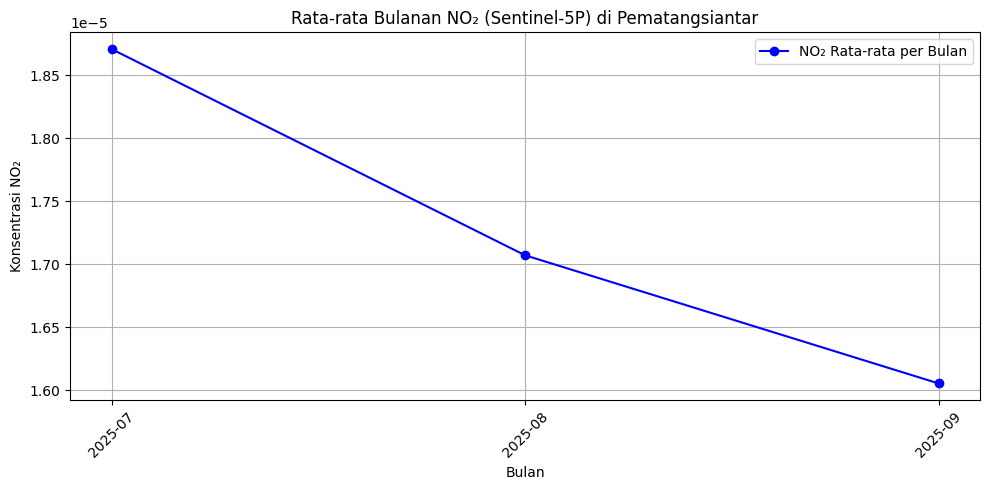

In [25]:
# Baca data
df = pd.read_csv("no2_results/no2_siantar_data.csv")

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# 13. Visualisasi hasil
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue", label="NO₂ Rata-rata per Bulan")
plt.title("Rata-rata Bulanan NO₂ (Sentinel-5P) di Pematangsiantar")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()